In [ ]:
# Install required libs
!sudo pip install -U segmentation-models-pytorch albumentations scikit-image --user 

In [ ]:
!sudo pip install scikit-image

In [ ]:
!sudo pip uninstall -y segmentation-models-pytorch scikit-image

## Loading data

In [1]:
import warnings
warnings.filterwarnings("ignore")

!nvidia-smi
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob, natsort

Sat Sep 11 12:07:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:02:00.0 Off |                  N/A |
| 41%   54C    P8    14W / 280W |  13201MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:03:00.0 Off |                  N/A |
| 41%   

In [2]:
# !nvidia-smi
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob, natsort

In [3]:
def count_nonzeros(flist):
    count = 0
    for idx in range(len(flist)):
        fname = flist[idx]
        mask = cv2.imread(fname)
        mask[mask!= 0] = 255
        if len(np.unique(mask))!= 1:
            count += 1
    P = count
    N = len(flist) - P
    print('P: {} ({:.2f}%) N: {} ({:.2f}%) Total: {}'.format(P, P/len(flist)*100, N, N/len(flist)*100, P+N))

flist = glob.glob('SSIM_seg/trainannot/*')
count_nonzeros(flist)
flist = glob.glob('SSIM_seg/valannot/*')
count_nonzeros(flist)
flist = glob.glob('SSIM_seg/testannot/*')
count_nonzeros(flist)

P: 75 (22.73%) N: 255 (77.27%) Total: 330
P: 14 (20.00%) N: 56 (80.00%) Total: 70
P: 21 (21.00%) N: 79 (79.00%) Total: 100


In [4]:
list_x = natsort.natsorted(glob.glob('SSIM_seg/train/'))
list_y = natsort.natsorted(glob.glob('SSIM_seg/trainannot/'))

list_x = natsort.natsorted(glob.glob('SSIM_seg/val/'))
list_y = natsort.natsorted(glob.glob('SSIM_seg/valannot/'))

list_x = natsort.natsorted(glob.glob('SSIM_seg/test/'))
list_y = natsort.natsorted(glob.glob('SSIM_seg/testannot/'))

list_x = natsort.natsorted(glob.glob('SSIM_cls/train/'))
list_y = natsort.natsorted(glob.glob('SSIM_cls/trainannot/'))

list_x = natsort.natsorted(glob.glob('SSIM_cls/val/*'))
list_y = natsort.natsorted(glob.glob('SSIM_cls/valannot/*'))

list_x = natsort.natsorted(glob.glob('SSIM_cls/test/*'))
list_y = natsort.natsorted(glob.glob('SSIM_cls/testannot/*'))

for idx in range(len(list_x)):
    if list_x[idx].split('/')[-1][:-3] != list_y[idx].split('/')[-1][:-3]:
        print(idx,list_x[idx],list_y[idx])

In [5]:
DATA_DIR = './SSIM_cls/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [6]:
# helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        if torch.is_tensor(image):
            image = image.permute(1,2,0)#.int()
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image,cmap='gray')
    plt.show()

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import pylab as plt

In [8]:
class Dataset(BaseDataset):
    """
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            augmentation=None, 
    ):
        self.images_fps = natsort.natsorted(glob.glob(images_dir+'/*'))
        self.masks_fps = natsort.natsorted(glob.glob(masks_dir+'/*'))
        self.augmentation = augmentation
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        fname = self.masks_fps[i]        
        if fname[-3:] == 'png':
            mask = cv2.imread(self.masks_fps[i], 0)
            mask = np.expand_dims(mask,-1)
            mask[mask!=0] = 1
            gt = np.array([1]) if np.count_nonzero(mask) else np.array([0])
            gt = gt.astype(np.float32)
        else:
            gt = np.load(self.masks_fps[i])
            gt = gt.astype(np.float32)
            mask = np.zeros_like(image)
            mask[mask==0] = 100
            
        # apply augmentations
        if self.augmentation:
            if -100 in mask:
                sample = self.augmentation(image=image)
                image = sample['image']
            else:
                sample = self.augmentation(image=image, mask=mask)
                image, mask = sample['image'], sample['mask']
        
        image = image.astype(np.float32)
        image = image/255.
        image = np.moveaxis(image,-1,0)
        image = torch.tensor(image)
        mask = mask.astype(np.float32)
        mask = np.moveaxis(mask,-1,0)
        mask = torch.tensor(mask)
        gt = torch.tensor(gt)
            
        return {'x' : image, 'y_seg' : mask, 'y_cls' : gt}
        
    def __len__(self):
        return len(self.images_fps)

### Augmentations

In [9]:
import albumentations as albu
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.05, rotate_limit=10, shift_limit=0.02, border_mode=4, p=.5),
        albu.IAAAdditiveGaussianNoise(scale=(1, 5),p=0.2),
        albu.IAAPerspective(scale=(0.01, 0.02),p=0.5),
        
        albu.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=False, p=0.5),
        albu.RandomGamma(gamma_limit=(80,120), p=.5),
        albu.RandomToneCurve(scale=0.1,p=.5), 
        albu.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=.5),

        albu.OneOf(
            [
                albu.IAASharpen(p=.5),        
                albu.GaussNoise(var_limit=0.02, mean=0, p=0.5),
                albu.MultiplicativeNoise(multiplier=(0.98, 1.02), p=0.5),
                albu.ISONoise(color_shift=(0.01, 0.02),intensity=(0.1, 0.3),p=0.5),
            ],
            p=0.5,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [

    ]
    return albu.Compose(test_transform)

In [10]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
#     preprocessing=get_preprocessing(),
)
# 
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
#     preprocessing=get_preprocessing(),
) 

test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
#     preprocessing=get_preprocessing(),
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([3, 256, 256]) torch.Size([1])
tensor([100.]) tensor([0.])


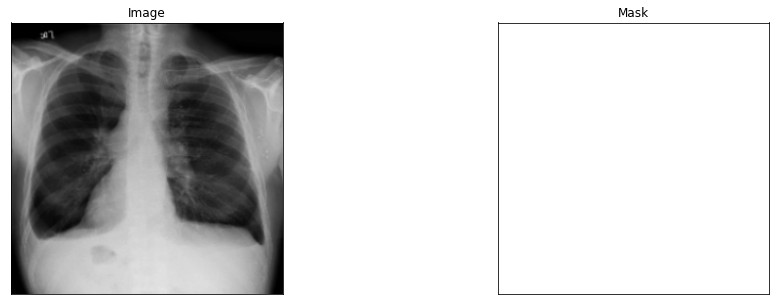

In [11]:
# same image with different random transforms

batch = next(iter(train_loader))
x = batch['x'][0]
y_seg = batch['y_seg'][0]
y_cls = batch['y_cls'][0]

print(x.shape,y_seg.shape,y_cls.shape)
print(torch.unique(y_seg),y_cls)
visualize(image=x, mask=y_seg)

## Create model and train

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import segmentation_models_pytorch as smp
import tqdm
from tqdm import trange

In [13]:
# ENCODER = 'resnet152'

# ENCODER_WEIGHTS = 'imagenet'
# ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
# DEVICE = 'cuda'

# aux_params=dict(
#     pooling='avg',             # one of 'avg', 'max'
#     dropout=0.5,               # dropout ratio, default is None
#     activation='sigmoid',      # activation function, default is None
#     classes=1,                 # define number of output labels
# )
# # aux_params=None

# # create segmentation model with pretrained encoder
# model = smp.Unet(
#     encoder_name=ENCODER, 
#     encoder_weights=ENCODER_WEIGHTS, 
#     classes=1, 
#     activation=ACTIVATION,
#     aux_params = aux_params,
# ).cuda()

import torchvision.models as tmodels
model = tmodels.resnet152(pretrained=True)
model.fc = nn.Sequential(nn.Linear(2048,1000),nn.Linear(1000,1),nn.Sigmoid())
model = model.cuda()

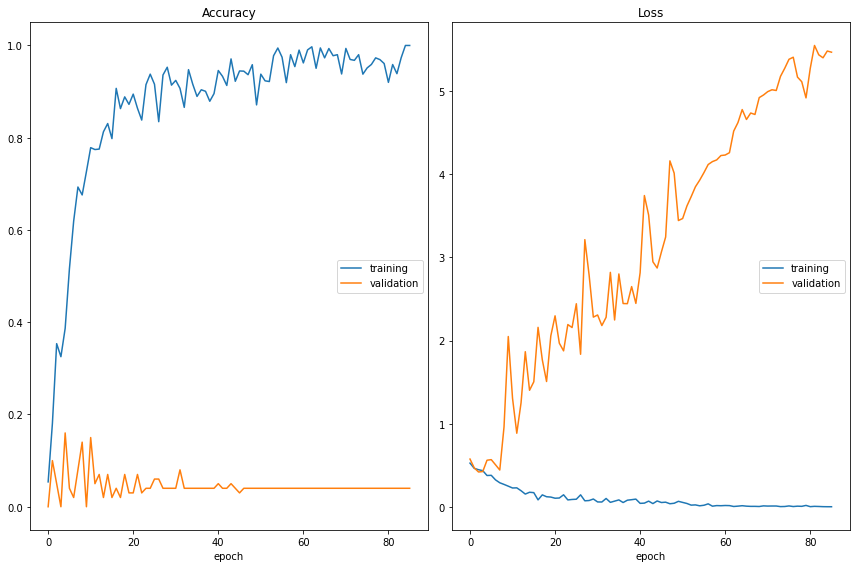

 86%|████████▌ | 86/100 [52:16<08:24, 36.01s/it]

Accuracy
	training         	 (min:    0.054, max:    1.000, cur:    1.000)
	validation       	 (min:    0.000, max:    0.160, cur:    0.040)
Loss
	training         	 (min:    0.002, max:    0.527, cur:    0.002)
	validation       	 (min:    0.420, max:    5.550, cur:    5.469)


In [ ]:
import monai
import sklearn
import sklearn.metrics

class DiceBCELoss(nn.Module):
    def __init__(self):        
        super(DiceBCELoss, self).__init__()
        self.dice = monai.losses.GeneralizedDiceLoss(sigmoid=False)
        self.ce = nn.BCELoss()        
        
    def forward(self,yhat,y):
        dice = self.dice(yhat,y)
        ce = self.ce(yhat,y)
        return dice+ce

class CELoss(nn.Module):
    def __init__(self):
        super(CELoss, self).__init__()
        self.ce = nn.CrossEntropyLoss(ignore_index= 100)
        
    def forward(self,yhat,y):
        y = y[:,0].long()
        loss = self.ce(yhat,y)
        return loss 

class DiceCELoss(nn.Module):
    def __init__(self):        
        super(DiceCELoss, self).__init__()
        self.dice = monai.losses.GeneralizedDiceLoss(to_onehot_y=True)
        self.ce = CELoss()        
        
    def forward(self,yhat,y):
        dice = self.dice(yhat,y)
        ce = self.ce(yhat,y)
        return dice+ce
    
epochs = 100
lossfn_cls = nn.BCELoss()
lossfn_seg = DiceCELoss()
# lossfn = DiceCELoss()
metric = sklearn.metrics.f1_score
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

def train():
    model.train()
    loss_epoch = list()
    acc_epoch = list()
    
    for idx, batch in enumerate(train_loader):
        x, y_seg, y_cls = batch['x'],batch['y_seg'],batch['y_cls'] 
        x, y_seg, y_cls = x.cuda(), y_seg.cuda(), y_cls.cuda()
        yhat = model(x)
        
        if isinstance(yhat,tuple):
            yhat_seg, yhat_cls = yhat
            loss_seg = lossfn_seg(yhat_seg,y_seg)
            loss = lossfn_cls(yhat_cls,y_cls) + loss_seg
            acc = metric(y_cls.cpu().detach().numpy().flatten(),yhat_cls.cpu().detach().numpy().flatten().round()) 
        else:
            loss = lossfn_cls(yhat,y_cls)
            acc = metric(y_cls.cpu().detach().numpy().flatten(),yhat.cpu().detach().numpy().flatten().round()) 
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_epoch.append(loss.cpu().detach().numpy())
        acc_epoch.append(acc)
        
    return np.mean(loss_epoch), np.mean(acc_epoch)

def valid():
    model.eval()
    loss_epoch = list()
    acc_epoch = list()
    
    for idx, batch in enumerate(valid_loader):
        x, y_seg, y_cls = batch['x'],batch['y_seg'],batch['y_cls'] 
        x, y_seg, y_cls = x.cuda(), y_seg.cuda(), y_cls.cuda()
        
        with torch.no_grad():
            yhat = model(x)
            if isinstance(yhat,tuple):
                yhat_seg, yhat_cls = yhat
                loss_seg = lossfn_seg(yhat_seg,y_seg)
                loss = lossfn_cls(yhat_cls,y_cls) + loss_seg
                acc = metric(y_cls.cpu().detach().numpy().flatten(),yhat_cls.cpu().detach().numpy().flatten().round()) 
            else:
                loss = lossfn_cls(yhat,y_cls)
                acc = metric(y_cls.cpu().detach().numpy().flatten(),yhat.cpu().detach().numpy().flatten().round()) 
            
        loss_epoch.append(loss.cpu().detach().numpy())
        acc_epoch.append(acc)
    return np.mean(loss_epoch), np.mean(acc_epoch)

def test():
    model.eval()
    
    xs = list()
    y_segs = list()
    y_clss = list()
    yhat_segs = list()
    yhat_clss = list()
    
    for idx, batch in tqdm.tqdm(enumerate(test_loader)):
        x, y_seg, y_cls = batch['x'],batch['y_seg'],batch['y_cls'] 
        xs.append(x)
        y_segs.append(y_seg)
        y_clss.append(y_cls)
        x, y_seg, y_cls = x.cuda(), y_seg.cuda(), y_cls.cuda()
        with torch.no_grad():
            yhat = model(x)            
            if isinstance(yhat,tuple):
                yhat_seg, yhat_cls = yhat
                yhat_segs.append(yhat_seg.cpu().detach().numpy())
                yhat_clss.append(yhat_cls.cpu().detach().numpy())
            else:
                yhat_clss.append(yhat.cpu().detach().numpy())
    return {'xs':xs,'y_segs':y_segs,'y_clss':y_clss, 'yhat_segs':yhat_segs, 'yhat_clss':yhat_clss}
    
from livelossplot import PlotLosses
plotlosses = PlotLosses()

loss_all = list()
acc_all = list()
val_loss_all = list()
val_acc_all = list()

for epoch in trange(epochs):
    loss, acc = train()
    loss_all.append(loss)
    acc_all.append(acc)
    val_loss, val_acc = valid()
    val_loss_all.append(val_loss)
    val_acc_all.append(val_acc)
    
    plotlosses.update({
        'acc': acc_all[-1],
        'val_acc': val_acc_all[-1],
        'loss': loss_all[-1],
        'val_loss': val_loss_all[-1]
    })
    plotlosses.send()
    
    if epoch == 50:
        optimizer.param_groups[0]['lr'] = 1e-5

# Result 

In [ ]:
result = test()

xs= result['xs']
y_segs = result['y_segs']
y_clss = result['y_clss']
yhat_segs = result['yhat_segs']
yhat_clss = result['yhat_clss']

In [ ]:
y_clss = [k.numpy()[0,0] for k in y_clss]
yhat_clss = [k[0,0].round() for k in yhat_clss]
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_clss, yhat_clss)
cm_display = ConfusionMatrixDisplay(cm).plot()
print(accuracy_score(y_clss, yhat_clss))

In [ ]:
for idx in range(len(y_clss)):
    print('idx: {} - GT:{} PRED:{}'.format(idx, y_clss[idx], yhat_clss[idx]))
    visualize(
        x=xs[idx][0], 
        y_seg=y_segs[idx][0], 
#         y_hat_segs=np.argmax(yhat_segs[idx][0],0),
#         y_hat_segs_processed=np.argmax(yhat_segs[idx][0],0)*yhat_clss[idx].round()
    )

In [ ]:
# loss = smp.utils.losses.BCELoss()+smp.utils.losses.DiceLoss()
# # import torch.nn as nn
# # loss = nn.BCELoss()

metrics = [
#     smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Accuracy(threshold=0.5),
]

# optimizer = torch.optim.Adam([ 
#     dict(params=model.parameters(), lr=0.001),
# ])

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
max_score = 0
from livelossplot import PlotLosses
plotlosses = PlotLosses()

for i in range(0, 100):    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['accuracy']:
        max_score = valid_logs['accuracy']
        torch.save(model, './best_model.pth')
        print('Model saved!')
    
    plotlosses.update({
        'acc': train_logs['accuracy'],
        'val_acc': valid_logs['accuracy'],
        'loss': train_logs['bce_loss + dice_loss'],
        'val_loss': valid_logs['bce_loss + dice_loss']
    })
    plotlosses.send()

    if i == 50:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

## Test best saved modelAdam

In [ ]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [ ]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(),
)

test_dataloader = DataLoader(test_dataset)

In [ ]:
# # evaluate model on test set
# test_epoch = smp.utils.train.ValidEpoch(
#     model=best_model,
#     loss=loss,
#     metrics=metrics,
#     device=DEVICE,
# )

# logs = test_epoch.run(test_dataloader)

## Visualize predictions

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
)

In [ ]:
for i in range(100):
    
    image_vis = test_dataset_vis[i][0].astype('uint8')
    image, gt_mask = test_dataset[i]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

In [ ]:
for i in range(10):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )